Structure obtained with avogadro in_avogadro_water.xyz

# Getting Started with Full-Frequency GW Calculations

##  Projective dielectric eigendecomposition (PDEP)

In the $\textbf{wstat.in}$ input file we compute 50 PDEPs, i.e., 50 eigenvectors of the static dielectric matrix. For production runs, please converge n_pdep_eigen. This step uses the occupied single-particle states and energies obtained in the previous step (mean-field calculation). Note that unoccupied states are not needed.

In summary, the $\textbf{Davidson algorithm}$ takes an initial guess for the lowest-eigenvalue eigenvector and produces new estimates by solving the diagonalization in an ever increasing subspace of previous estimates. Starting from that initial guess, the algorithm goes as follows.

In [3]:
import json
#JSON (JavaScript Object Notation) is an open standard file format and data interchange format that uses human-readable text to store and transmit data objects 
#consisting of name–value pairs and arrays (or other serializable values). 
import numpy as np

# Load the output data contained in the file <west_prefix>.wstat.save/wstat.json.
with open('/home/paolo/water_2/water_pbe/water_pbe.wstat.save/wstat.json') as json_file :
    data1 = json.load(json_file)

#The system performed various Davidson iterations to obtain the converged PDEP. We extract the corresponding eigenvalues of the last iteration
# Extract converged PDEP eigenvalues, stored in the position wstat.json[exec][davitr][-1 (last iteration)][ev]
ev = np.array(data1['exec']['davitr'][-1]['ev'],dtype='f8') # -1 identifies the last iteration

In [4]:
#list of converged PDEP eigenvalues
print(ev)

[-2.50793906 -1.06306151 -0.77589256 -0.7374752  -0.62302457 -0.51556865
 -0.48781758 -0.3495011  -0.34077426 -0.31898838 -0.30151811 -0.29073281
 -0.28644069 -0.25385046 -0.22810214 -0.21396446 -0.19176811 -0.18468644
 -0.17838223 -0.1554166  -0.15284546 -0.14676629 -0.14488876 -0.14419548
 -0.13943264 -0.10469511 -0.09562784 -0.09041826 -0.0897679  -0.0859008
 -0.07729071 -0.0764719  -0.07570843 -0.0654883  -0.06362753 -0.06173222
 -0.06131231 -0.05984806 -0.05846643 -0.05766444 -0.05585663 -0.05330921
 -0.05271778 -0.05195627 -0.04916528 -0.04838885 -0.04183438 -0.041417
 -0.04096953 -0.04049671]


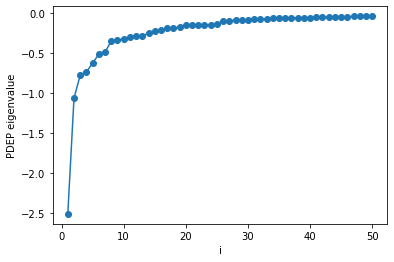

In [5]:
import matplotlib.pyplot as plt

# Create x-axis, by generating an array of evenly spaced points equal to the number of PDEP
iv = np.linspace(1,ev.size,ev.size,endpoint=True)

# Plot
plt.plot(iv,ev,'o-')
plt.xlabel('i')
plt.ylabel('PDEP eigenvalue')

plt.show()

As we can see the eigenvalues of the dielectric response decay to zero (see J. Chem. Theory Comput. 11, 2680 (2015), and references therein). The number of PDEPs is a parameter of the simulation that is system dependent and needs to be converged. Typically the number of PDEPs is set equal to multiple of the number of electrons.

## Contour deformation (CD)

In [6]:
# Read the output of Wfreq: wfreq.json

def wfreq2df(filename='/home/paolo/water_2/water_pbe/water_pbe.wfreq.save/wfreq.json', dfKeys=['eks','eqpLin','eqpSec','sigmax','sigmac_eks','sigmac_eqpLin','sigmac_eqpSec', 'vxcl', 'vxcnl', 'hf']) :

    # read data from JSON file

    import json
    with open(filename) as file :
        data = json.load(file)

    import numpy as np
    import pandas as pd

    # build the dataframe with pandas
    # build the columns: k->k-point index (always 1, sampled at gamma), s->spin index, n: state index (We computed the quasiparticle corrections of states 
    #identified by band indexes 1,2,3,4,5, see input file wfreq.in). With + dfKeys we add to the column array the names of another list of column names, namely eks, eqpLin, ...
    columns = ['k','s','n'] + dfKeys
    #build the dataframe
    df = pd.DataFrame(columns=columns)

    # insert data into the dataframe
    j = 0
    #run over the spin from 1 to the data extracted from wfreq.json->system->electron->nspin+1 (since for runs from 0 to n-1). In our case s=1 so the for performs a single run.
    for s in range(1,data['system']['electron']['nspin']+1) :
        #run over k points extracted from wfreq.json->system->bzsamp->k
        for k in data['system']['bzsamp']['k'] :
            #f-string (formatted string literal) to generate a string, as part of a labeling or identifier system. The index kindex is computed by summing k['id'], value extracted
            #from wfreq.json->system->bzsamp->k->id, to a scaling factor that multiplies the adjusted value of s by the length of the list k. 
            #:06d is a format specification in the f-string, it means that the result inside the curly braces will be formatted as a decimal integer (d), with leading zeros to make the total width 6 characters. 
            #If the value is smaller than 6 digits, it will be padded with zeros. In the present case s=1 so this additive term is =0.
            kindex = f"K{k['id']+(s-1)*len(data['system']['bzsamp']['k']):06d}"
            #The output is extracted from wfreq.json->output->Q->kindex. Since in our case k=1, the output is contained entirely in the file K000001 (padded to zero to fill the 6
            #digits)
            d = data['output']['Q'][kindex]
            #enumerate() is a built-in Python function that takes an iterable (in this case, the list data['input']['wfreq_control']['qp_bands'][s - 1]) and 
            #returns both the index (i) and the value (n) for each element of the iterable. The values contained in the dictionary in this case are:
            #    0:1
            #    1:2
            #    2:3
            #    3:4
            #    4:5
            for i, n in enumerate(data['input']['wfreq_control']['qp_bands'][s - 1]) :
                #A new list row is created, starting with three elements: k['id'], defined previously, spin index s and the current state index n. 
                row = [k['id'], s, n]
                #for key in dfKeys iterates over dfKeys, which is the list of keys eks, eqpLin, ...
                for key in dfKeys :
                    #if 're' in d[key] checks if the key in dictionary d contains the subkey 're', i.e. real.
                    if 're' in d[key] :
                        #If 're' is present, it appends d[key]['re'][i] (the i-th element from the list d[key]['re']) to the row.
                        row.append(d[key]['re'][i])
                    else :
                        #If 're' is not found, it appends d[key][i] (the i-th element from d[key]) to the row.
                        row.append(d[key][i])
                #df.loc[j] = row inserts the row into the DataFrame df at row index j. Each time the loop iterates, a new row is added to the DataFrame df.        
                df.loc[j] = row
                #After adding the row, the index j is incremented by 1, so the next iteration adds data to the next row in the DataFrame.
                j += 1

    # cast the columns k, s, n to int
    df['k'] = df['k'].apply(np.int64)
    df['s'] = df['s'].apply(np.int64)
    df['n'] = df['n'].apply(np.int64)

    return df, data

In [7]:
df, data = wfreq2df()
display(df)

,k,s,n,eks,eqpLin,eqpSec,sigmax,sigmac_eks,sigmac_eqpLin,sigmac_eqpSec,vxcl,vxcnl,hf
0,1,1,1,-25.024032,-24.839963,-29.839128,-31.578976,4.996174,7.306641,6.994422,-19.649824,0.0,-11.929152
1,1,1,2,-12.137710,-17.076248,-16.910485,-23.214158,0.432002,1.319449,1.244348,-17.138977,0.0,-6.075180
2,1,1,3,-9.619320,-14.284605,-14.093985,-24.037721,1.016440,1.999408,1.967215,-17.596162,0.0,-6.441560
3,1,1,4,-7.060595,-11.551913,-11.389068,-24.779717,1.410616,2.418333,2.398029,-18.116756,0.0,-6.662961
4,1,1,5,-1.239055,1.019796,1.134220,-2.184044,-0.629367,-0.599149,-0.592624,-5.149398,0.0,2.965353


All energies in the plot are reported in eV. The full-frequency $G_0 W_0$ energies correspond to the $\textbf{eqpSec}$ column.

From the table we see that HOMO has an energy of -7.061 eV at PBE, while HOMO has an energy of -11.389 eV at 
$G_0 W_0$@PBE without linearization.

## Explanation of keys 

$$\textbf{k}: \text{k-point index}$$

$$\textbf{s}: \text{spin index}$$

$$\textbf{n}: \text{state index}$$

$$\textbf{eks}: \epsilon_{kn}, \, \text{Kohn-Sham energy (obtained in Step 1, DFT calculation)}$$

$$\textbf{eqpLin}: E_{kn}, \, \text{quasiparticle energy (full-frequency } G_0W_0@PBE \text{), obtained by approximating the self-energy to first order in the frequency}$$

$$\textbf{eqpSec}: E_{kn}, \, \text{quasiparticle energy (full-frequency } G_0W_0@PBE \text{), obtained by using the secant method to solve the frequency-dependency in the quasiparticle equation}$$

$$\textbf{sigmax}: \text{exchange self-energy}$$

$$\textbf{sigmac_eks}: \text{correlation self-energy, evaluated at eks. Note that $\textbf{re}$ and $\textbf{im}$ identify the real and imaginary parts.}$$

$$\textbf{sigmac_eqpLin}: \text{correlation self-energy, evaluated at eqpLin}$$

$$\textbf{sigmac_eqpSec}: \text{correlation self-energy, evaluated at eqpSec}$$

$$\textbf{vxcl}: \text{contribution to the energy given by the semi-local xc functional}$$

$$\textbf{vxcnl}: \text{contribution to the energy given by the exact exchange (if the xc is hybrid)}$$

$$\textbf{hf}: \text{quasiparticle energy according to perturbative Hartree-Fock, i.e., no correlation self-energy}$$

$$\textbf{z}: \text{the value of the z-parameter used to approximate the self-energy to first order in the frequency (definition given in J. Chem. Theory Comput. 11, 2680 (2015))}$$

# Analyzing the Frequency Dependency in GW Calculations

We analyze the frequency dependency of the GW self-energy, by exploring two ways of solving the Quasiparticle equation:
without linearization
\begin{equation}
E = \epsilon_{ks} + \langle \Sigma(E) - V_{Hxc} \rangle
\end{equation}
or with linearization
\begin{equation}
E = \epsilon_{ks} + \langle \Sigma(\epsilon_{ks}) - V_{Hxc} \rangle + (E - \epsilon_{ks}) \langle \frac{\partial \Sigma}{\partial E}(\epsilon_{ks})\rangle
\end{equation}

In [8]:
import json
import numpy as np

# Load the output data
with open('/home/paolo/water_2/water_pbe/water_pbe.wfreq.save/wfreq_1.json') as json_file :
    data2 = json.load(json_file)

# Extract converged quasiparticle (QP) corrections
k = 1
kindex = f'K{k:06d}'

qp_bands = data2['input']['wfreq_control']['qp_bands'][0]
eqp = data2['output']['Q'][kindex]

freqlist = np.array(data2['output']['P']['freqlist'], dtype='f8')
spf = data2['output']['P'][kindex]

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     4      |     -7.061      |     -11.550     |     -11.371    


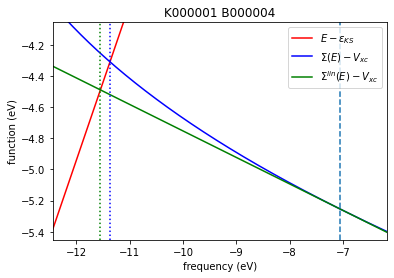

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     5      |     -1.239      |      1.020      |      1.134     


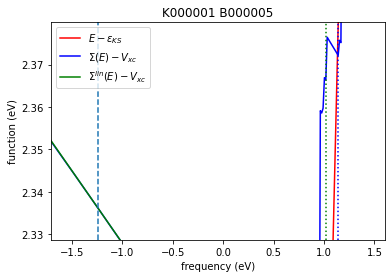

In [9]:
# Plot
import matplotlib.pyplot as plt

for i, c in enumerate(qp_bands) :
 
    eks, eqpLin, eqpSec = eqp['eks'][i], eqp['eqpLin'][i], eqp['eqpSec'][i]

    # Print QP corrections
    print (f"{'k':^10} | {'band':^10} | {'eks [eV]':^15} | {'eqpLin [eV]':^15} | {'eqpSec [eV]':^15}")
    print(77*'-')
    print(f'{k:^10} | {c:^10} | {eks:^15.3f} | {eqpLin:^15.3f} | {eqpSec:^15.3f}')

    sigmax, vxcl, vxcnl = eqp['sigmax'][i], eqp['vxcl'][i], eqp['vxcnl'][i]
    sigmac_eks = eqp['sigmac_eks']['re'][i]
    sigmac_eqpLin = eqp['sigmac_eqpLin']['re'][i]
    sigmac_eqpSec = eqp['sigmac_eqpSec']['re'][i]
    z = eqp['z'][i]

    bindex = f'B{c:06d}'
    sigmac = np.array(spf[bindex]['sigmac']['re'], dtype='f8')

    # Left-hand side of QP equation
    plt.plot(freqlist,freqlist-eks,'r-',label=r'$E-\varepsilon_{KS}$')

    # Right-hand side of QP equation without linearization
    plt.plot(freqlist,sigmac+sigmax-vxcl-vxcnl,'b-',label=r'$\Sigma(E)-V_{xc}$')

    # Right-hand side of QP equation with linearization
    plt.plot(freqlist,sigmac_eks+sigmax-vxcl-vxcnl+(1-1/z)*(freqlist-eks),'g-',label=r'$\Sigma^{lin}(E)-V_{xc}$')

    plt.legend()
    plt.title(kindex+" "+bindex)
    plt.xlabel('frequency (eV)')
    plt.ylabel('function (eV)')
    xmin, xmax = min(eks, eqpLin, eqpSec), max(eks, eqpLin, eqpSec)
    ymin, ymax = min(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec), max(sigmac_eks, sigmac_eqpLin, sigmac_eqpSec)
    ymin += sigmax - vxcl -vxcnl
    ymax += sigmax - vxcl -vxcnl
    plt.vlines(x=eks,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls="--")
    plt.vlines(x=eqpLin,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":",color="g")
    plt.vlines(x=eqpSec,ymin=ymin-0.2*(ymax-ymin),ymax=ymax+0.2*(ymax-ymin),ls=":",color="b")
    plt.xlim([xmin-0.2*(xmax-xmin),xmax+0.2*(xmax-xmin)])
    plt.ylim([ymin-0.2*(ymax-ymin),ymax+0.2*(ymax-ymin)])
    plt.show()

# Hybrid computation

A hybrid functional contains a mixture of semilocal ($V_{\text{x}}$) and exact exchange ($V_{\text{xx}}$):

\begin{equation}
H^{\text{hyb}}= T + V_{\text{ion}} + V_{\text{Hartree}} + V_{\text{xc}} + \alpha (V_{\text{xx}}-V_{\text{x}})
\end{equation}

For the hybrid functional PBE0 $\alpha=0.25$.

A class of dielectric dependent hybrid functionals was developed in order to make $\alpha$ material dependent and to obtain higher accuracy. For dielectric dependent hybrid functionals $\alpha$ is a parameter that can be determined from first principles:

- For solids (sc-hybrid functional): $\alpha = \epsilon_\infty^{-1}$ [[Phys. Rev. B 89, 195112 (2014)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.195112)]
- For molecules (SX functional): $\alpha_n = \frac{\left\langle \psi_n \right| \Sigma_{\text{SEX}} \left | \psi_n \right\rangle}{\left\langle \psi_n \right| \Sigma_{\text{EX}} \left | \psi_n \right\rangle}$ [[Phys. Rev. X 6, 041002 (2016)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.6.041002)]


\begin{equation}
\Sigma_{\text{SEX}}(\mathbf{r},\mathbf{r^\prime}) = -\sum_n^{N_{\text{states}}} \psi_n(\mathbf{r}) W(\mathbf{r},\mathbf{r^\prime}) \psi^\ast_n(\mathbf{r^\prime})
\end{equation}
and
\begin{equation}
\Sigma_{\text{EX}}(\mathbf{r},\mathbf{r^\prime}) = -\sum_n^{N_{\text{states}}} \psi_n(\mathbf{r}) v_{Coulomb}(\mathbf{r},\mathbf{r^\prime}) \psi^\ast_n(\mathbf{r^\prime})
\end{equation}

In order to compute the SX constant we need to compute the DFT electronic structure with semilocal functionals (`pw.x`), compute the eigendecomposition of the dielectric screening (`wstat.x`), and extract the information about the screening with the WEST post-processing tool (`westpp.x`).

At westpp_6.json -> output -> fraction -> 3

In [1]:
# alpha_n following the definition given for molecules
exx_fration = 0.7280307620399332

Corrected result, new dft calculation